In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
%tensorflow_version 1.x
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import glob
import copy
import time

In [0]:
'''fit the image to the background (when needed)'''
import cv2

def fit_to_background(image):
  image = image.squeeze()
  _, res = cv2.threshold(src=image, thresh=10, maxval=255, type=cv2.THRESH_BINARY)
  res = np.where(res>0, 255, 0).astype(np.uint8)
  _, cnts, _ = cv2.findContours(res, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
  x, y, w, h = cv2.boundingRect(cnts[0])
  image = image[y:y+h, x:x+w]
  image = cv2.resize(src=image, dsize=(400, 400))
  return image

In [0]:
path = './drive/My Drive/small_caries_dataset/Healthy/**.jpg'
neg_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  img = fit_to_background(img)
  img = np.expand_dims(a=img, axis=-1)
  neg_images.append(img)

neg_images = np.array(neg_images)
print('num healthy images:', len(neg_images))

num healthy images: 238


In [0]:
path = './drive/My Drive/small_caries_dataset/Caries/**.jpg'
pos_images = list()
for img_name in glob.glob(pathname=path):
  img = load_img(path=img_name, color_mode='grayscale')
  img = img_to_array(img=img, data_format='channels_last')
  img = fit_to_background(img)
  img = np.expand_dims(a=img, axis=-1)
  pos_images.append(img)

pos_images = np.array(pos_images)
print('num carious images:', len(pos_images))

num carious images: 45


In [0]:
num_iter = int(len(neg_images) / len(pos_images))-1
generated_pos_images = copy.deepcopy(x=pos_images)
for _ in range(num_iter):
  new_pos_images = copy.deepcopy(x=pos_images)
  generated_pos_images = np.concatenate((generated_pos_images, new_pos_images))

print('num repeated carious images:', len(generated_pos_images))

num repeated carious images: 225


In [0]:
neg_labels = [0 for _ in range(len(neg_images))]
pos_labels = [1 for _ in range(len(generated_pos_images))]

In [0]:
X = np.concatenate((generated_pos_images, neg_images))
y = np.array(pos_labels + neg_labels)

print('num total dataset images:', len(X))
print('num total dataset labels:', len(y))

num total dataset images: 463
num total dataset labels: 463


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
from keras import Model
inputA = Input(shape=X_train[0].shape)

x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(inputA)
x1 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x)
x2 = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(x1)
x3 = MaxPooling2D(pool_size=2, strides=2, padding='same')(x2)
x4 = Flatten()(x3)
x5 = Dense(units=10, activation='relu')(x4)
x6 = Dense(units=1, activation='sigmoid')(x5)
net = Model(inputs=inputA, outputs=x6)

In [0]:
from keras import optimizers

net.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
net.summary()

In [0]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=[1., 2.], 
                         width_shift_range=0.25, height_shift_range=0.25, 
                         shear_range=0.15, horizontal_flip=True, 
                         vertical_flip=True, fill_mode='nearest')

test_aug = ImageDataGenerator(rescale=1./255)

In [0]:
# from keras.callbacks import LambdaCallback
# weights = LambdaCallback(on_epoch_end=lambda batch, logs: print(net.layers[10].get_weights()))

t0 = time.time()
net.fit_generator(generator=aug.flow(x=X_train, y=y_train, batch_size=8), 
                  steps_per_epoch=None, epochs=10, verbose=1)

t1 = time.time()
print('total training time: %.2f secs' % (round(t1-t0, ndigits=2)))

In [0]:
from sklearn.metrics import confusion_matrix

y_pred = net.predict_generator(generator=test_aug.flow(x=X_test, batch_size=1),
                               steps=len(X_test))
y_test = np.reshape(a=y_test, newshape=(1, -1))

print('num test-set images:', len(y_test[0]))
print(y_test)
y_pred = np.round(np.reshape(a=y_pred, newshape=(1, -1)))
print(y_pred)
# print(np.reshape(a=y_pred, newshape=(1, -1)))

cm = confusion_matrix(y_true=y_test[0], y_pred=y_pred[0])
print(cm)
print('test-set acc:', (cm[0][0] + cm[1][1])/np.sum(cm))

map generation time: 37.13 secs


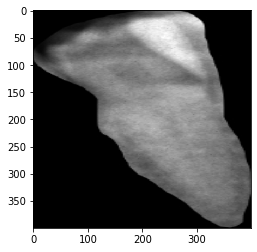

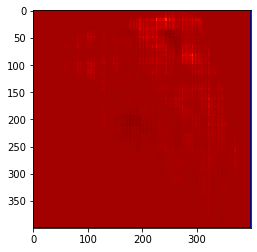

In [0]:
img = X_test[10] / 255.
k_sz = 3
prob_map = np.zeros(shape=img.shape)
t0 = time.time()
for row_idx in range(0, img.shape[1]-k_sz, k_sz):
  for col_idx in range(0, img.shape[0]-k_sz, k_sz):
    masked = copy.deepcopy(x=img)
    masked[row_idx:row_idx+k_sz, col_idx:col_idx+k_sz] = 0
    prob = net.predict(x=masked.reshape(1, img.shape[0], img.shape[1], 1))
    # print(prob)
    prob_map[row_idx:row_idx+k_sz, col_idx:col_idx+k_sz] = 1 - prob

t1 = time.time()
print('map generation time: %.2f secs' % (round(t1-t0, ndigits=2)))
plt.imshow(img.squeeze(), cmap='gray')
plt.show()
plt.imshow(prob_map.squeeze(), cmap='jet')
plt.show()